# Geographic Filter for Hydrological Stations

This notebook provides functionality to filter precipitation stations based on geographic boundaries (latitude/longitude). This is useful when you want to focus analysis on stations near a specific river basin or catchment area.

## Overview

The notebook will:
1. Make backup copies of original data files to an "Original" folder
2. Ask for geographic bounds (min/max latitude and longitude)
3. Filter the station metadata based on these geographic bounds
4. Filter the precipitation data to include only stations within the bounds
5. Save the filtered data in the same format as the originals

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

## 1. Set File Paths and Create Backup Directory

In [16]:
# Configure file paths - update these to match your actual file locations
data_dir = "../data"  # Main data directory
station_metadata_file = os.path.join(data_dir, "station_metadata.xlsx")  # Update with actual file name
observed_precip_file = os.path.join(data_dir, "observed_precip.xlsx")    # Update with actual file name

# Check if files exist and determine their formats
if not os.path.exists(station_metadata_file):
    station_metadata_file = station_metadata_file.replace('.xlsx', '.csv')
if not os.path.exists(observed_precip_file):
    observed_precip_file = observed_precip_file.replace('.xlsx', '.csv')

print(f"Station metadata file: {station_metadata_file}")
print(f"Observed precipitation file: {observed_precip_file}")

# Create backup directory
backup_dir = os.path.join(data_dir, "Original")
os.makedirs(backup_dir, exist_ok=True)
print(f"Created backup directory: {backup_dir}")

Station metadata file: ../data\station_metadata.xlsx
Observed precipitation file: ../data\observed_precip.xlsx
Created backup directory: ../data\Original


## 2. Make Backup Copies of Original Files

In [17]:
# Function to create backups
def backup_file(file_path, backup_dir):
    """
    Create a backup copy of a file in the backup directory
    """
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} does not exist")
        return False
    
    filename = os.path.basename(file_path)
    backup_path = os.path.join(backup_dir, filename)
    
    # Create backup if it doesn't exist already
    if not os.path.exists(backup_path):
        shutil.copy2(file_path, backup_path)
        print(f"Backed up {filename} to {backup_dir}")
    else:
        print(f"Backup already exists for {filename}")
    
    return True

# Create backups
backup_file(station_metadata_file, backup_dir)
backup_file(observed_precip_file, backup_dir)

Backed up station_metadata.xlsx to ../data\Original
Backed up observed_precip.xlsx to ../data\Original


True

## 3. Load Data Files

In [18]:
# Function to load data file (handles both Excel and CSV)
def load_data(file_path):
    """
    Load data from Excel or CSV file
    """
    if not os.path.exists(file_path):
        print(f"Error: {file_path} does not exist")
        return None
    
    if file_path.endswith('.xlsx') or file_path.endswith('.xls'):
        return pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    else:
        print(f"Error: Unsupported file format for {file_path}")
        return None

# Load the data files
station_metadata = load_data(station_metadata_file)
observed_precip = load_data(observed_precip_file)

# Display basic information about the files
if station_metadata is not None:
    print(f"\nStation Metadata - {station_metadata.shape[0]} stations, {station_metadata.shape[1]} columns")
    print("Columns:", station_metadata.columns.tolist())
    display(station_metadata.head())

if observed_precip is not None:
    print(f"\nObserved Precipitation - {observed_precip.shape[0]} records, {observed_precip.shape[1]} columns")
    # Only show a few representative columns
    precip_cols = observed_precip.columns.tolist()
    display_cols = precip_cols[:5] + ['...'] + precip_cols[-5:] if len(precip_cols) > 10 else precip_cols
    print("Columns sample:", display_cols)
    display(observed_precip.head())


Station Metadata - 308 stations, 4 columns
Columns: ['Station ID', 'lon', 'lat', 'elevation']


,Station ID,lon,lat,elevation
0,101,80.500000,29.650000,842
1,102,80.416667,29.550000,1635
2,103,80.533333,29.466667,1266
3,104,80.583333,29.300000,1848
4,105,80.216667,29.033333,176



Observed Precipitation - 10957 records, 311 columns
Columns sample: [101, 102, 103, 104, 105, '...', 1420, 1421, 'year', 'month', 'days']


,101,102,103,104,105,106,107,108,201,202,...,1411,1412,1415,1416,1419,1420,1421,year,month,days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.4,0.0,0.0,0.0,1986,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1986,1,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1986,1,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1986,1,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.1,0.0,0.0,0.0,1986,1,5


## 4. Standardize Column Names

Make sure we have standardized column names to work with. This handles different naming conventions in the metadata file.

In [19]:
# Identify column names in station metadata
id_col = None
lat_col = None
lon_col = None

# Check for station ID column
for col in ['Station ID', 'Station_ID', 'StationID', 'id', 'ID', 'station_id']:
    if col in station_metadata.columns:
        id_col = col
        break

# Check for latitude column
for col in ['lat', 'Lat', 'latitude', 'Latitude', 'LAT']:
    if col in station_metadata.columns:
        lat_col = col
        break

# Check for longitude column
for col in ['lon', 'Lon', 'Long', 'longitude', 'Longitude', 'LON']:
    if col in station_metadata.columns:
        lon_col = col
        break

if id_col is None or lat_col is None or lon_col is None:
    print("Error: Could not identify required columns in station metadata")
    print(f"Looking for: station ID, latitude, longitude")
    print(f"Found columns: {station_metadata.columns.tolist()}")
else:
    print(f"Identified columns: ID={id_col}, Latitude={lat_col}, Longitude={lon_col}")

Identified columns: ID=Station ID, Latitude=lat, Longitude=lon


## 5. Explore Station Locations

Visualize the station locations to help identify appropriate geographic boundaries

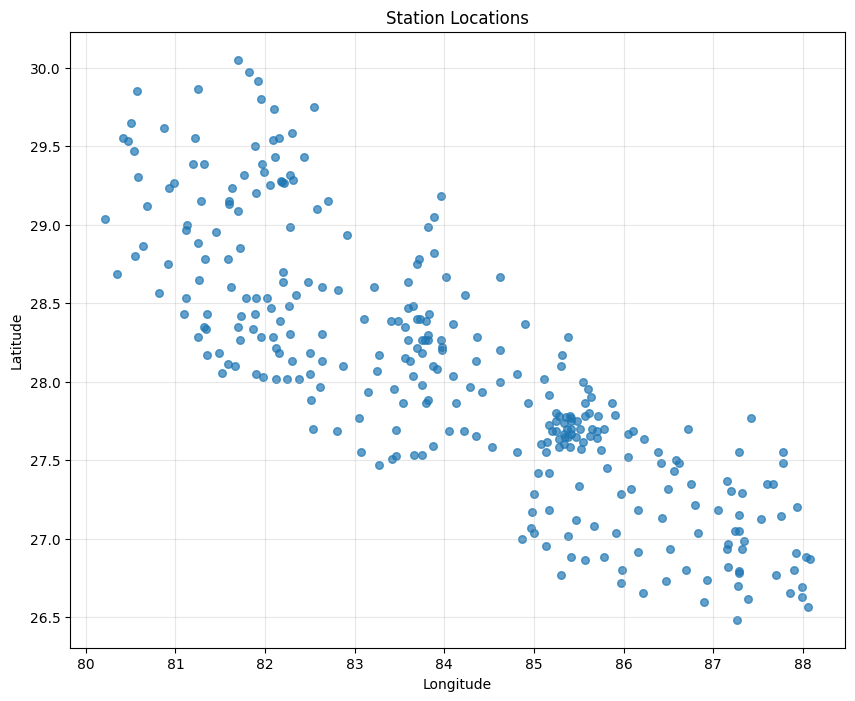

Latitude range: 26.483333333333 to 30.05
Longitude range: 80.2166666699999 to 88.078333333333


In [20]:
# Plot station locations if latitude and longitude columns are identified
if lat_col is not None and lon_col is not None:
    plt.figure(figsize=(10, 8))
    plt.scatter(station_metadata[lon_col], station_metadata[lat_col], s=30, alpha=0.7)
    
    # Add station IDs as labels if not too many stations
    if len(station_metadata) <= 50:
        for idx, row in station_metadata.iterrows():
            plt.annotate(str(row[id_col]), 
                        (row[lon_col], row[lat_col]),
                        xytext=(3, 3),
                        textcoords='offset points',
                        fontsize=8)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Station Locations')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Also display the coordinates range to help user decide bounds
    print(f"Latitude range: {station_metadata[lat_col].min()} to {station_metadata[lat_col].max()}")
    print(f"Longitude range: {station_metadata[lon_col].min()} to {station_metadata[lon_col].max()}")

## 6. Define Geographic Bounds

Enter the minimum and maximum latitude and longitude to filter stations

In [21]:
# User input for geographic bounds
min_lat = float(input("Enter minimum latitude: "))
max_lat = float(input("Enter maximum latitude: "))
min_lon = float(input("Enter minimum longitude: "))
max_lon = float(input("Enter maximum longitude: "))

print(f"\nDefined geographic bounds:")
print(f"Latitude: {min_lat} to {max_lat}")
print(f"Longitude: {min_lon} to {max_lon}")


Defined geographic bounds:
Latitude: 27.537 to 27.819
Longitude: 85.1919 to 85.5272


## 7. Filter Stations Based on Geographic Bounds

Filtered 23 out of 308 stations within the bounds


,Station ID,lon,lat,elevation
195,1007,85.250000,27.800000,2064
198,1015,85.200000,27.683333,1630
203,1022,85.400000,27.583333,1400
208,1029,85.333333,27.666667,1350
209,1030,85.366667,27.700000,1337


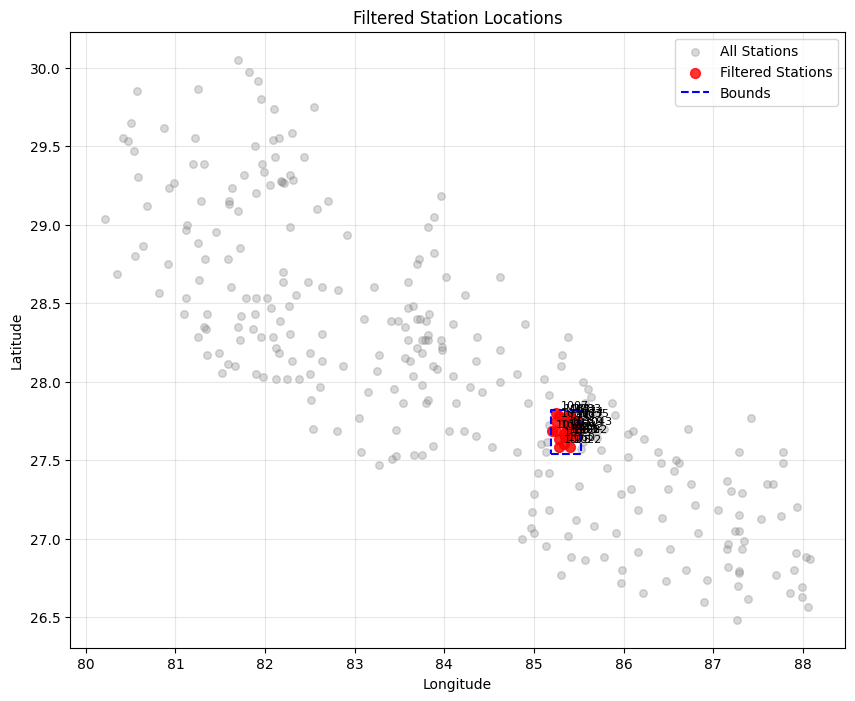

In [22]:
# Filter stations within the specified bounds
filtered_stations = station_metadata[
    (station_metadata[lat_col] >= min_lat) & 
    (station_metadata[lat_col] <= max_lat) & 
    (station_metadata[lon_col] >= min_lon) & 
    (station_metadata[lon_col] <= max_lon)
]

print(f"Filtered {len(filtered_stations)} out of {len(station_metadata)} stations within the bounds")
display(filtered_stations.head())

# Visualize filtered stations
plt.figure(figsize=(10, 8))

# Plot all stations as a reference
plt.scatter(station_metadata[lon_col], station_metadata[lat_col], s=30, alpha=0.3, color='gray', label='All Stations')

# Highlight filtered stations
plt.scatter(filtered_stations[lon_col], filtered_stations[lat_col], s=50, alpha=0.8, color='red', label='Filtered Stations')

# Add geographic bounds rectangle
plt.plot([min_lon, max_lon, max_lon, min_lon, min_lon], 
         [min_lat, min_lat, max_lat, max_lat, min_lat], 
         'b--', label='Bounds')

# Add labels for filtered stations
for idx, row in filtered_stations.iterrows():
    plt.annotate(str(row[id_col]), 
                (row[lon_col], row[lat_col]),
                xytext=(3, 3),
                textcoords='offset points',
                fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Filtered Station Locations')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## 8. Extract Station IDs and Filter Precipitation Data

In [25]:
# Get the list of station IDs to keep
stations_to_keep = filtered_stations[id_col].astype(str).tolist()
print(f"Stations to keep: {stations_to_keep}")

# Function to identify date columns in precipitation data
def identify_date_columns(df):
    """Identify columns related to dates"""
    date_cols = []
    for col in df.columns:
        col_lower = str(col).lower()
        if any(term in col_lower for term in ['date', 'year', 'month', 'day', 'time']):
            date_cols.append(col)
    return date_cols

# Identify date-related columns in precipitation data
date_columns = identify_date_columns(observed_precip)
print(f"Date-related columns: {date_columns}")

# First, check which format the station IDs are in the precipitation data
# They might be plain numbers or prefixed with 'Station_'
precip_columns = [col for col in observed_precip.columns if col not in date_columns]
sample_station_cols = precip_columns[:10] if len(precip_columns) > 10 else precip_columns
print(f"Sample precipitation columns: {sample_station_cols}")

# Check if we need to prefix 'Station_' to the IDs
prefix_station = False
if any(str(col).startswith('Station_') for col in precip_columns):
    prefix_station = True
    print("Station columns appear to be prefixed with 'Station_'")
    stations_to_keep = [f"Station_{station}" for station in stations_to_keep]
    print(f"Updated stations to keep: {stations_to_keep}")

# Replace the existing station matching code with this:
# Convert your filtered station IDs to integers for matching with precipitation columns
existing_stations = []
for col in precip_columns:
    # Check if this precipitation column is in our filtered stations
    if col in [int(station) for station in stations_to_keep if station.isdigit()]:
        existing_stations.append(col)
        print(f"Matched precipitation column {col}")

if not existing_stations:
    # If no direct matches, check if stations might be in a different format
    print("\nTrying alternative matching approach...")
    # Try to convert both to strings and check partial matches
    for station in stations_to_keep:
        matching_cols = [col for col in precip_columns if str(col) in station or station in str(col)]
        if matching_cols:
            existing_stations.extend(matching_cols)
            print(f"Matched station {station} to columns {matching_cols}")
            
missing_stations = [station for station in stations_to_keep if station not in observed_precip.columns]

if missing_stations:
    print(f"Warning: {len(missing_stations)} stations from metadata not found in precipitation data")
    print(f"Missing stations: {missing_stations}")

if not existing_stations:
    print("Error: None of the filtered stations were found in the precipitation data")
    print("Check how station IDs are formatted in both files")
else:
    # Filter the precipitation data
    columns_to_keep = date_columns + existing_stations
    filtered_precip = observed_precip[columns_to_keep]
    
    print(f"\nFiltered precipitation data to {len(existing_stations)} stations")
    print(f"Original shape: {observed_precip.shape}, Filtered shape: {filtered_precip.shape}")
    display(filtered_precip.head())

Stations to keep: ['1007', '1015', '1022', '1029', '1030', '1035', '1039', '1043', '1052', '1059', '1060', '1061', '1071', '1073', '1074', '1075', '1076', '1077', '1079', '1080', '1081', '1082', '1083']
Date-related columns: ['year', 'month', 'days']
Sample precipitation columns: [101, 102, 103, 104, 105, 106, 107, 108, 201, 202]
Matched precipitation column 1007
Matched precipitation column 1015
Matched precipitation column 1022
Matched precipitation column 1029
Matched precipitation column 1030
Matched precipitation column 1035
Matched precipitation column 1039
Matched precipitation column 1043
Matched precipitation column 1052
Matched precipitation column 1059
Matched precipitation column 1060
Matched precipitation column 1061
Matched precipitation column 1071
Matched precipitation column 1073
Matched precipitation column 1074
Matched precipitation column 1075
Matched precipitation column 1076
Matched precipitation column 1077
Matched precipitation column 1079
Matched precipitation 

,year,month,days,1007,1015,1022,1029,1030,1035,1039,...,1073,1074,1075,1076,1077,1079,1080,1081,1082,1083
0,1986,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 9. Save Filtered Data to New Files

In [26]:
# Function to save data in the same format as the original
def save_data(df, original_file_path):
    """
    Save DataFrame in the same format as the original file
    """
    # Get file extension and directory
    file_ext = os.path.splitext(original_file_path)[1].lower()
    file_dir = os.path.dirname(original_file_path)
    file_name = os.path.basename(original_file_path)
    
    # Create new filename with 'filtered_' prefix
    new_file_name = f"filtered_{file_name}"
    new_file_path = os.path.join(file_dir, new_file_name)
    
    # Save based on file extension
    if file_ext in ['.xlsx', '.xls']:
        df.to_excel(new_file_path, index=False)
    elif file_ext == '.csv':
        df.to_csv(new_file_path, index=False)
    else:
        print(f"Unsupported file format: {file_ext}. Saving as CSV instead.")
        new_file_path = new_file_path.replace(file_ext, '.csv')
        df.to_csv(new_file_path, index=False)
    
    print(f"Saved filtered data to {new_file_path}")
    return new_file_path

# Save filtered data
if 'filtered_precip' in locals() and 'filtered_stations' in locals():
    new_metadata_path = save_data(filtered_stations, station_metadata_file)
    new_precip_path = save_data(filtered_precip, observed_precip_file)
    
    print("\nFiltering complete! You can now use these filtered files for your hydrological analysis.")
    print(f"Filtered station metadata: {new_metadata_path}")
    print(f"Filtered precipitation data: {new_precip_path}")
else:
    print("Error: Filtering was not successful. Please check the previous steps.")

Saved filtered data to ../data\filtered_station_metadata.xlsx
Saved filtered data to ../data\filtered_observed_precip.xlsx

Filtering complete! You can now use these filtered files for your hydrological analysis.
Filtered station metadata: ../data\filtered_station_metadata.xlsx
Filtered precipitation data: ../data\filtered_observed_precip.xlsx


## 10. Final Summary and Recommendations

In [ ]:
# Display final summary statistics
if 'filtered_precip' in locals() and 'filtered_stations' in locals():
    total_stations = len(station_metadata)
    filtered_station_count = len(filtered_stations)
    
    # Calculate precipitation statistics
    original_cols = len(observed_precip.columns) - len(date_columns)
    filtered_cols = len(filtered_precip.columns) - len(date_columns)
    
    print("\nFinal Summary:")
    print(f"1. Geographic Bounds: Lat [{min_lat} to {max_lat}], Lon [{min_lon} to {max_lon}]")
    print(f"2. Station Metadata: {filtered_station_count} of {total_stations} stations kept ({filtered_station_count/total_stations*100:.1f}%)")
    print(f"3. Precipitation Data: {filtered_cols} of {original_cols} stations kept ({filtered_cols/original_cols*100:.1f}%)")
    
    # Check for potential issues
    if filtered_station_count < 5:
        print("\nWarning: Very few stations were kept. Consider expanding your geographic bounds.")
    
    if len(missing_stations) / len(stations_to_keep) > 0.5:
        print("\nWarning: Many stations from metadata were not found in precipitation data.")
        print("This may indicate a mismatch in station ID formats between files.")
    
    print("\nNext Steps:")
    print("1. Replace your original files with the filtered versions for analysis")
    print("2. Original files are backed up in the 'Original' folder if needed")
    print("3. Proceed with your hydrological analysis using the filtered dataset")